# Test Case 9 - Oscillating Circuit

In [88]:
from CircuitCalculator.Circuit.state_space_model import state_space_model
from CircuitCalculator.Circuit.circuit import Circuit
from CircuitCalculator.Circuit import components as cmp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Setup Circuit

In [89]:
V0 = 5
R1, R2, R3 = 2, 20, 30
L = 2e-3
C = 0.5e-3
circuit = Circuit([
    cmp.dc_voltage_source(id='Vq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.inductance(id='L', L=L, nodes=('2', '3')),
    cmp.capacitor(id='C', C=C, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [90]:
from CircuitCalculator.Circuit.circuit import transform_circuit
network = transform_circuit(circuit, w=0)

### Setup Solution

In [91]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [92]:
t_max = 0.02
t0 = 0.001
Ts = t_max/1000
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

### Calculate Solution

In [93]:
import CircuitCalculator.Network.NodalAnalysis.label_mapping as map
import itertools
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
from numpy.linalg import inv
node_mapper = map.default_node_mapper
voltage_source_mapper = map.alphabetic_voltage_source_mapper
current_source_mapper = map.alphabetic_current_source_mapper

In [94]:
c_values = {'C': C}
l_values = {'L': L}

In [95]:
node_mapping = node_mapper(network)
def element_incidence_matrix(values: dict[str, float]) -> np.ndarray:
    Delta = np.zeros((len(values), node_mapping.N))
    for (k, value), (i_label) in itertools.product(enumerate(values), node_mapping):
        if i_label == network[value].node1:
            Delta[k][node_mapping(i_label)] = +1
        if i_label == network[value].node2:
            Delta[k][node_mapping(i_label)] = -1
    return np.hstack((Delta, np.zeros((Delta.shape[0], voltage_source_mapper(network).N))))

voltage_source_mapping = map.filter(voltage_source_mapper(network), lambda x: x in l_values)
voltage_source_mapping_all = voltage_source_mapper(network)
source_mapping_all = map.default_source_mapper(network)

Qi = source_incidence_matrix(network=network)
Q = np.zeros((voltage_source_mapping_all.N, voltage_source_mapping_all.N), dtype=int)
for i in voltage_source_mapping_all.values:
    Q[i][i] = 1
Q = np.vstack((np.hstack( (Qi, np.zeros((Qi.shape[0], Q.shape[1]) ))),
                np.hstack( (np.zeros((Q.shape[0], Qi.shape[1])), Q) )))

QS = Q[:,[source_mapping_all[l] for l in source_mapping_all if l not in l_values]]
QL = Q[:,[source_mapping_all[l] for l in source_mapping_all if l in l_values]]

Delta = element_incidence_matrix(c_values)
A_tilde = nodal_analysis_coefficient_matrix(network).real

DQ = np.hstack((Delta.T, QL))
CL = np.array([[-C, 0], [0, L]])

A = inv(DQ.T @ inv(A_tilde) @ DQ @ CL)
B = -A @ DQ.T @ inv(A_tilde) @ QS
C = inv(A_tilde) @ DQ @ CL @ A
D = inv(A_tilde) @ (QS + DQ @ CL @ B)

print(A)
print(B)
print(C)
print(D)

[[   -0.  2000.]
 [ -500. -1000.]]
[[  0.]
 [500.]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.00000000e+00]
 [ 1.00000000e+00  4.16333634e-17]
 [ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00]]
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [96]:
# ssm = state_space_model(circuit=circuit, potential_nodes=['1', '2', '3'], voltage_ids=['Vq', 'R1', 'R2', 'R3', 'L'], current_ids=['R1', 'R2', 'R3', 'L', 'Vq'])
sys = signal.StateSpace(A, B, C, D)
tout, yout, xout = signal.lsim(sys, V, t)

### Calculate Reference Solution

In [97]:
# def pll(R1, R2):
#     return R1*R2/(R1+R2)

# Ri = pll(R1, R2)+R3
# tau = L/Ri

# iL_ref = V*R2/(R1*R2+R1*R3+R2*R3)*(1-np.exp(-(tout-t0)/tau))
# uL_ref = V*R2/(R1*R2+R1*R3+R2*R3)*np.exp(-(tout-t0)/tau)*L/tau

# phi3_ref = uL_ref
# phi2_ref = R3*iL_ref+phi3_ref
# phi1_ref = V

# uR1_ref = phi1_ref-phi2_ref
# uR2_ref = phi2_ref
# uR3_ref = phi2_ref-phi3_ref

# iS_ref = (phi2_ref-phi1_ref)/R1
# iR1_ref = -iS_ref
# iR2_ref = iR1_ref - iL_ref
# iR3_ref = iL_ref

phi1_ref = np.zeros(tout.shape)
phi2_ref = np.zeros(tout.shape)
phi3_ref = np.zeros(tout.shape)

### Plot Solution

(0.0, 0.02)

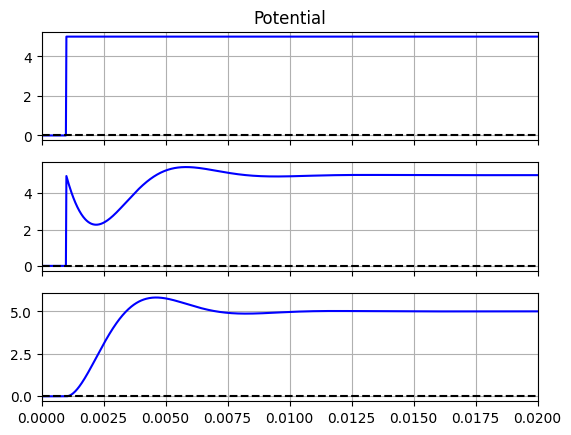

In [98]:
_, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(tout, yout[:,0], 'b-')
ax[0].plot(t, phi1_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Potential')

ax[1].plot(tout, yout[:,1], 'b-')
ax[1].plot(tout, phi2_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,2], 'b-')
ax[2].plot(tout, phi3_ref, 'k--')
ax[2].grid(True)
ax[2].set_xlim((0, t_max))

In [99]:
# _, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))
# ax[0].plot(tout, yout[:,3], 'b-')
# ax[0].plot(t, V, 'k--')
# ax[0].grid(True)
# ax[0].set_title('Voltages')

# ax[1].plot(tout, yout[:,4], 'b-')
# ax[1].plot(tout, uR1_ref, 'k--')
# ax[1].grid(True)

# ax[2].plot(tout, yout[:,5], 'b-')
# ax[2].plot(tout, uR2_ref, 'k--')
# ax[2].grid(True)

# ax[3].plot(tout, yout[:,6], 'b-')
# ax[3].plot(tout, uR3_ref, 'k--')
# ax[3].grid(True)

# ax[4].plot(tout, yout[:,7], 'b-')
# ax[4].plot(tout, uL_ref, 'k--')
# ax[4].grid(True)
# ax[4].set_xlim((0, t_max))

(0.0, 0.02)

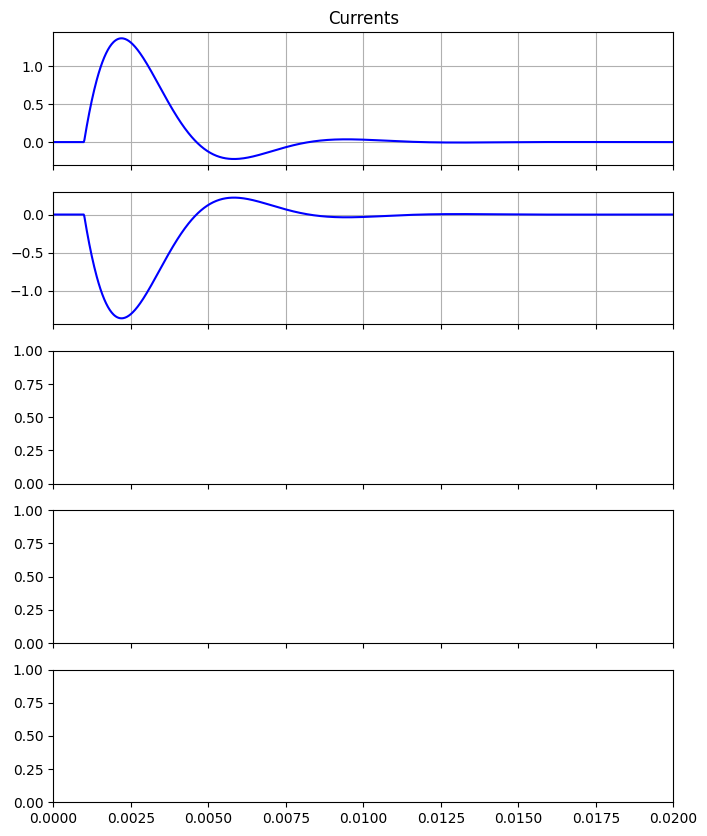

In [100]:
_, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))
ax[0].plot(tout, yout[:,3], 'b-')
# ax[0].plot(t, iR1_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Currents')

ax[1].plot(tout, yout[:,4], 'b-')
# ax[1].plot(tout, iR2_ref, 'k--')
ax[1].grid(True)

# ax[2].plot(tout, yout[:,10], 'b-')
# ax[2].plot(tout, iR3_ref, 'k--')
# ax[2].grid(True)

# ax[3].plot(tout, yout[:,11], 'b-')
# ax[3].plot(tout, iL_ref, 'k--')
# ax[3].grid(True)

# ax[4].plot(tout, yout[:,12], 'b-')
# ax[4].plot(tout, iS_ref, 'k--')
# ax[4].grid(True)
ax[4].set_xlim((0, t_max))